In [118]:
import rsatools
from floc_selectivity import floc_selectivity
import importlib
import numpy as np
import pandas as pd
import nibabel as nib
import os
from os import listdir
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform,cosine,euclidean,mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats

importlib.reload(rsatools)

<module 'rsatools' from '/home/jacobpri/git/RotspaceIT/notebooks/rsatools.py'>

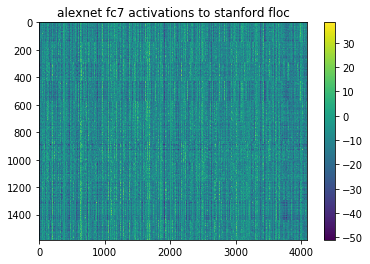

In [50]:
proj_dir = '/home/jacobpri/Exploring-NSD/'
trainset = 'Object'
layer = '19_linear7'
fn_loc = join(proj_dir,'activations/shared1000/AlexNet-' + trainset + '/vpnl_floc/' + layer + '.npy')

# load and reshape if necessary
Y_loc = np.squeeze(np.load(fn_loc))
if np.ndim(Y_loc) == 2:
    Y_loc = Y_loc.T[:,:]
else:
    Y_loc = np.reshape(Y_loc,(Y_loc.shape[0]*Y_loc.shape[1]*Y_loc.shape[2],Y_loc.shape[3])).T[:,:]
    
# visualize
plt.figure()
plt.imshow(Y_loc,aspect='auto')
plt.colorbar()
plt.title('alexnet fc7 activations to stanford floc');

In [53]:
floc_categs = np.array(['adult','body','car','child','corridor','house','instrument','limb','number','scrambled','word'])
floc_domains = np.array(['faces','bodies','objects','scenes','characters','scrambled'])
floc_categ_domain_ref = np.array([0,1,2,0,3,3,2,1,4,5,4])
categ_nimg = 144

floc_domain_idx = np.repeat(floc_categ_domain_ref,categ_nimg)

assert(len(floc_domain_idx) == Y_loc.shape[0])
assert(categ_nimg * len(floc_categs) == Y_loc.shape[0])

In [54]:
pref_dict = floc_selectivity(Y_loc, floc_domain_idx)

In [57]:
Y_face = Y_loc[:,pref_dict['domain_idx'][0]]
Y_scene = Y_loc[:,pref_dict['domain_idx'][3]]
print(Y_face.shape, Y_scene.shape)

(1584, 497) (1584, 191)


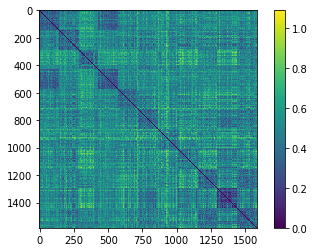

In [94]:
# rdv function: compute rdv from 2d matrix using pearson dissim

Y_face_rdv = rsatools.rdv(Y_face)
Y_scene_rdv = rsatools.rdv(Y_scene)

plt.imshow(squareform(Y_face_rdv))
plt.colorbar()

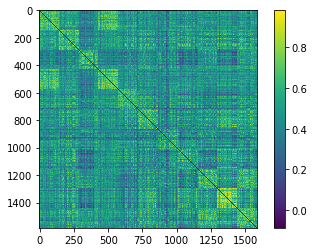

In [95]:
# rsm2rdm function: convert back and forth between similarity and dissimilarity

Y_face_rsm = rsatools.rsm2rdm(Y_face_rdv)

plt.imshow(squareform(Y_face_rsm))
plt.colorbar()

In [119]:
# validator functions for rdvcorr
print(rsatools.assert_distmat(Y_face)) # should be false
print(rsatools.assert_distmat(squareform(Y_face_rdv))) # should be true
print(rsatools.assert_distmat(rsatools.rsm2rdm(squareform(Y_face_rdv)))) # should also be true


False
True
True


In [103]:
# rdvcorr function: compute correlation between rdvs

# case 1: from data matrices
r = rsatools.rdvcorr(Y_face, Y_scene)
print(r)

# case 2: from rdvs
r = rsatools.rdvcorr(Y_face_rdv, Y_scene_rdv)
print(r)

# case 3: from rdms
r = rsatools.rdvcorr(squareform(Y_face_rdv), squareform(Y_scene_rdv))
print(r)

# case 4: one is data mat, one is rdv
#r = rsatools.rdvcorr(Y_face, Y_scene_rdv)
#print(r)

0.8527786057160646
0.8527786057160646
0.8527786057160646


In [111]:
# correlating rdv from one piece of data with a list of rdvs

# make a list of 4 data sources
neuron_idx = np.array([500, 1500, 2500, 3500])

Y_list = []
for idx in neuron_idx:
    Y_list.append(Y_loc[:,idx:idx+250])
    
print(len(Y_list))
print(Y_list[0].shape)

# pearson corrs
print(rsatools.rdvcorr_list(Y_face, Y_list))

# use cosine dist to make the distance matrices now
print(rsatools.rdvcorr_list(Y_face, Y_list, dist = 'cosine'))

# use euclidean dist to make the distance matrices now
print(rsatools.rdvcorr_list(Y_face, Y_list, dist = 'euclidean'))

4
(1584, 250)
[0.8579163621338003, 0.8592429697866102, 0.8867827302123005, 0.8728676470817117]
[0.4849309399361149, 0.5040285789080824, 0.4358860552465551, 0.5061347983252567]
[0.7782673731097235, 0.775067584731426, 0.7421497092017594, 0.7743720633955189]
